# **Tool Wear Prediction**

# **1. Overview**

Prediction concept
* From dataset in this topic, Consist of 18 files of experiment record and another train data. 
* I decided to combine train dataset of each experiment number into new column of experiment dataset. 
* Choose feature to training model for predict feedrate and clamp_pressure.
* Get feedrate_predicted and clamp_pressure_predicted to training model for classify tool_condition

# **2. Import libraries**

In [150]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score


# **3. Load the dataset**

In [151]:
prefix = 'https://raw.githubusercontent.com/APL-Data-Intelligence/AceleraAI/main/Curso_NEED/datasets/cnc_dataset/'
train=pd.read_csv(prefix + 'train.csv')

Use function .info() for describe train dataframe

In [152]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        18 non-null     int64  
 1   material                  18 non-null     object 
 2   feedrate                  18 non-null     int64  
 3   clamp_pressure            18 non-null     float64
 4   tool_condition            18 non-null     object 
 5   machining_finalized       18 non-null     object 
 6   passed_visual_inspection  14 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ KB
None


Use function .head() for show the first data 5 row 

In [153]:
print(train.head())

   No material  feedrate  clamp_pressure tool_condition machining_finalized  \
0   1      wax         6             4.0         unworn                 yes   
1   2      wax        20             4.0         unworn                 yes   
2   3      wax         6             3.0         unworn                 yes   
3   4      wax         6             2.5         unworn                  no   
4   5      wax        20             3.0         unworn                  no   

  passed_visual_inspection  
0                      yes  
1                      yes  
2                      yes  
3                      NaN  
4                      NaN  


# **4. Pre-Processing**

**Label Encoding**
   
       Use function "LabelEncoder" to transform non-numerical labels to numerical labels

In [154]:
le2=LabelEncoder()
le2.fit(train['tool_condition'])
train['Encoded_tool_condition']=le2.transform(train['tool_condition'])

le3=LabelEncoder()
le3.fit(train['machining_finalized'])
train['Encoded_machining_finalized']=le3.transform(train['machining_finalized'])

le4=LabelEncoder()
le4.fit(train['feedrate'])
train['Encoded_feedrate']=le4.transform(train['feedrate'])

le5=LabelEncoder()
le5.fit(train['clamp_pressure'])
train['Encoded_clamp_pressure']=le5.transform(train['clamp_pressure'])

        Use function .drop() remove columns by specifying label names

In [155]:
train.drop(['passed_visual_inspection','tool_condition','material','machining_finalized'],axis=1,inplace=True)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   No                           18 non-null     int64  
 1   feedrate                     18 non-null     int64  
 2   clamp_pressure               18 non-null     float64
 3   Encoded_tool_condition       18 non-null     int64  
 4   Encoded_machining_finalized  18 non-null     int64  
 5   Encoded_feedrate             18 non-null     int64  
 6   Encoded_clamp_pressure       18 non-null     int64  
dtypes: float64(1), int64(6)
memory usage: 1.1 KB
None


**Feature Selection**

        plot the correlation heatmap and see the correlation of independent variables with the output variable

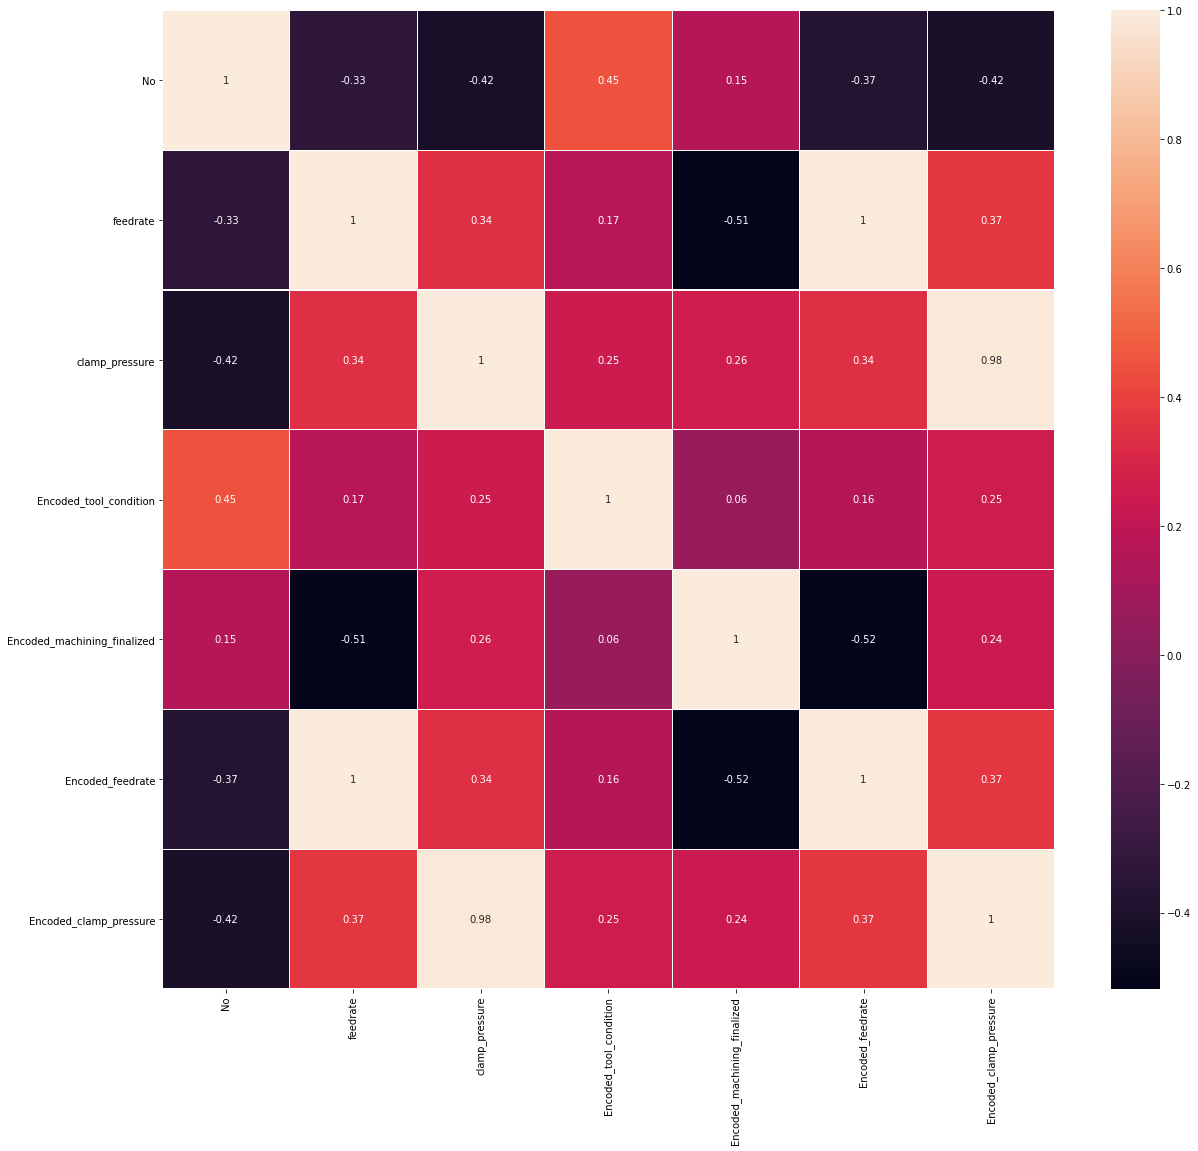

In [156]:
plt.figure(figsize=(20,18))
sns.heatmap(train.corr(),linewidths=.1,annot=True)
plt.show()

**Import experiment data**

*         Loop for read each 'experiments_{n}' data
*         Add column "Encoded_feedrate", "Encoded_clamp_pressure" index i of 'train' add to 'frames'

In [157]:
frames = []
for i in range(1,19):
    ex_num = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv(prefix + "experiment_{}.csv".format(ex_num))

    ex_result_row = train[train['No'] == i]

    le6=LabelEncoder()
    le6.fit(frame['Machining_Process'])
    frame['Encoded_Machining_Process']=le6.transform(frame['Machining_Process'])
    frame.drop('Machining_Process', axis=1, inplace=True)

    frame['Encoded_feedrate'] = ex_result_row.iloc[0]['Encoded_feedrate']
    frame['Encoded_tool_condition'] =ex_result_row.iloc[0]['Encoded_tool_condition']
    frame['Encoded_clamp_pressure'] = ex_result_row.iloc[0]['Encoded_clamp_pressure']
    frames.append(frame)



        Assign 'frames' (experiments data no. 1-18) into new dataframe 'df'

In [158]:
df = pd.concat(frames, ignore_index=True)
print(df.head(3))
print(df.shape)

   X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                   0.00   
1              198.0              -10.8                -350.00   
2              196.0              -17.8                  -6.25   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                0.000000   
1               198.0               -13.6             -358.000000   
2               196.0               -17.9               -0.000095   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   
2               -8.59           0.1400             328.0             30.60   

   X1_OutputPower  Y1_ActualPosition  Y1_ActualVelocity  \
0       -0.000001              158.0             -0.025   
1        0.004480          

        Plot the correlation heatmap and see the correlation of independent variables with the output variable

>>>>> Heatmap of frames <<<<<


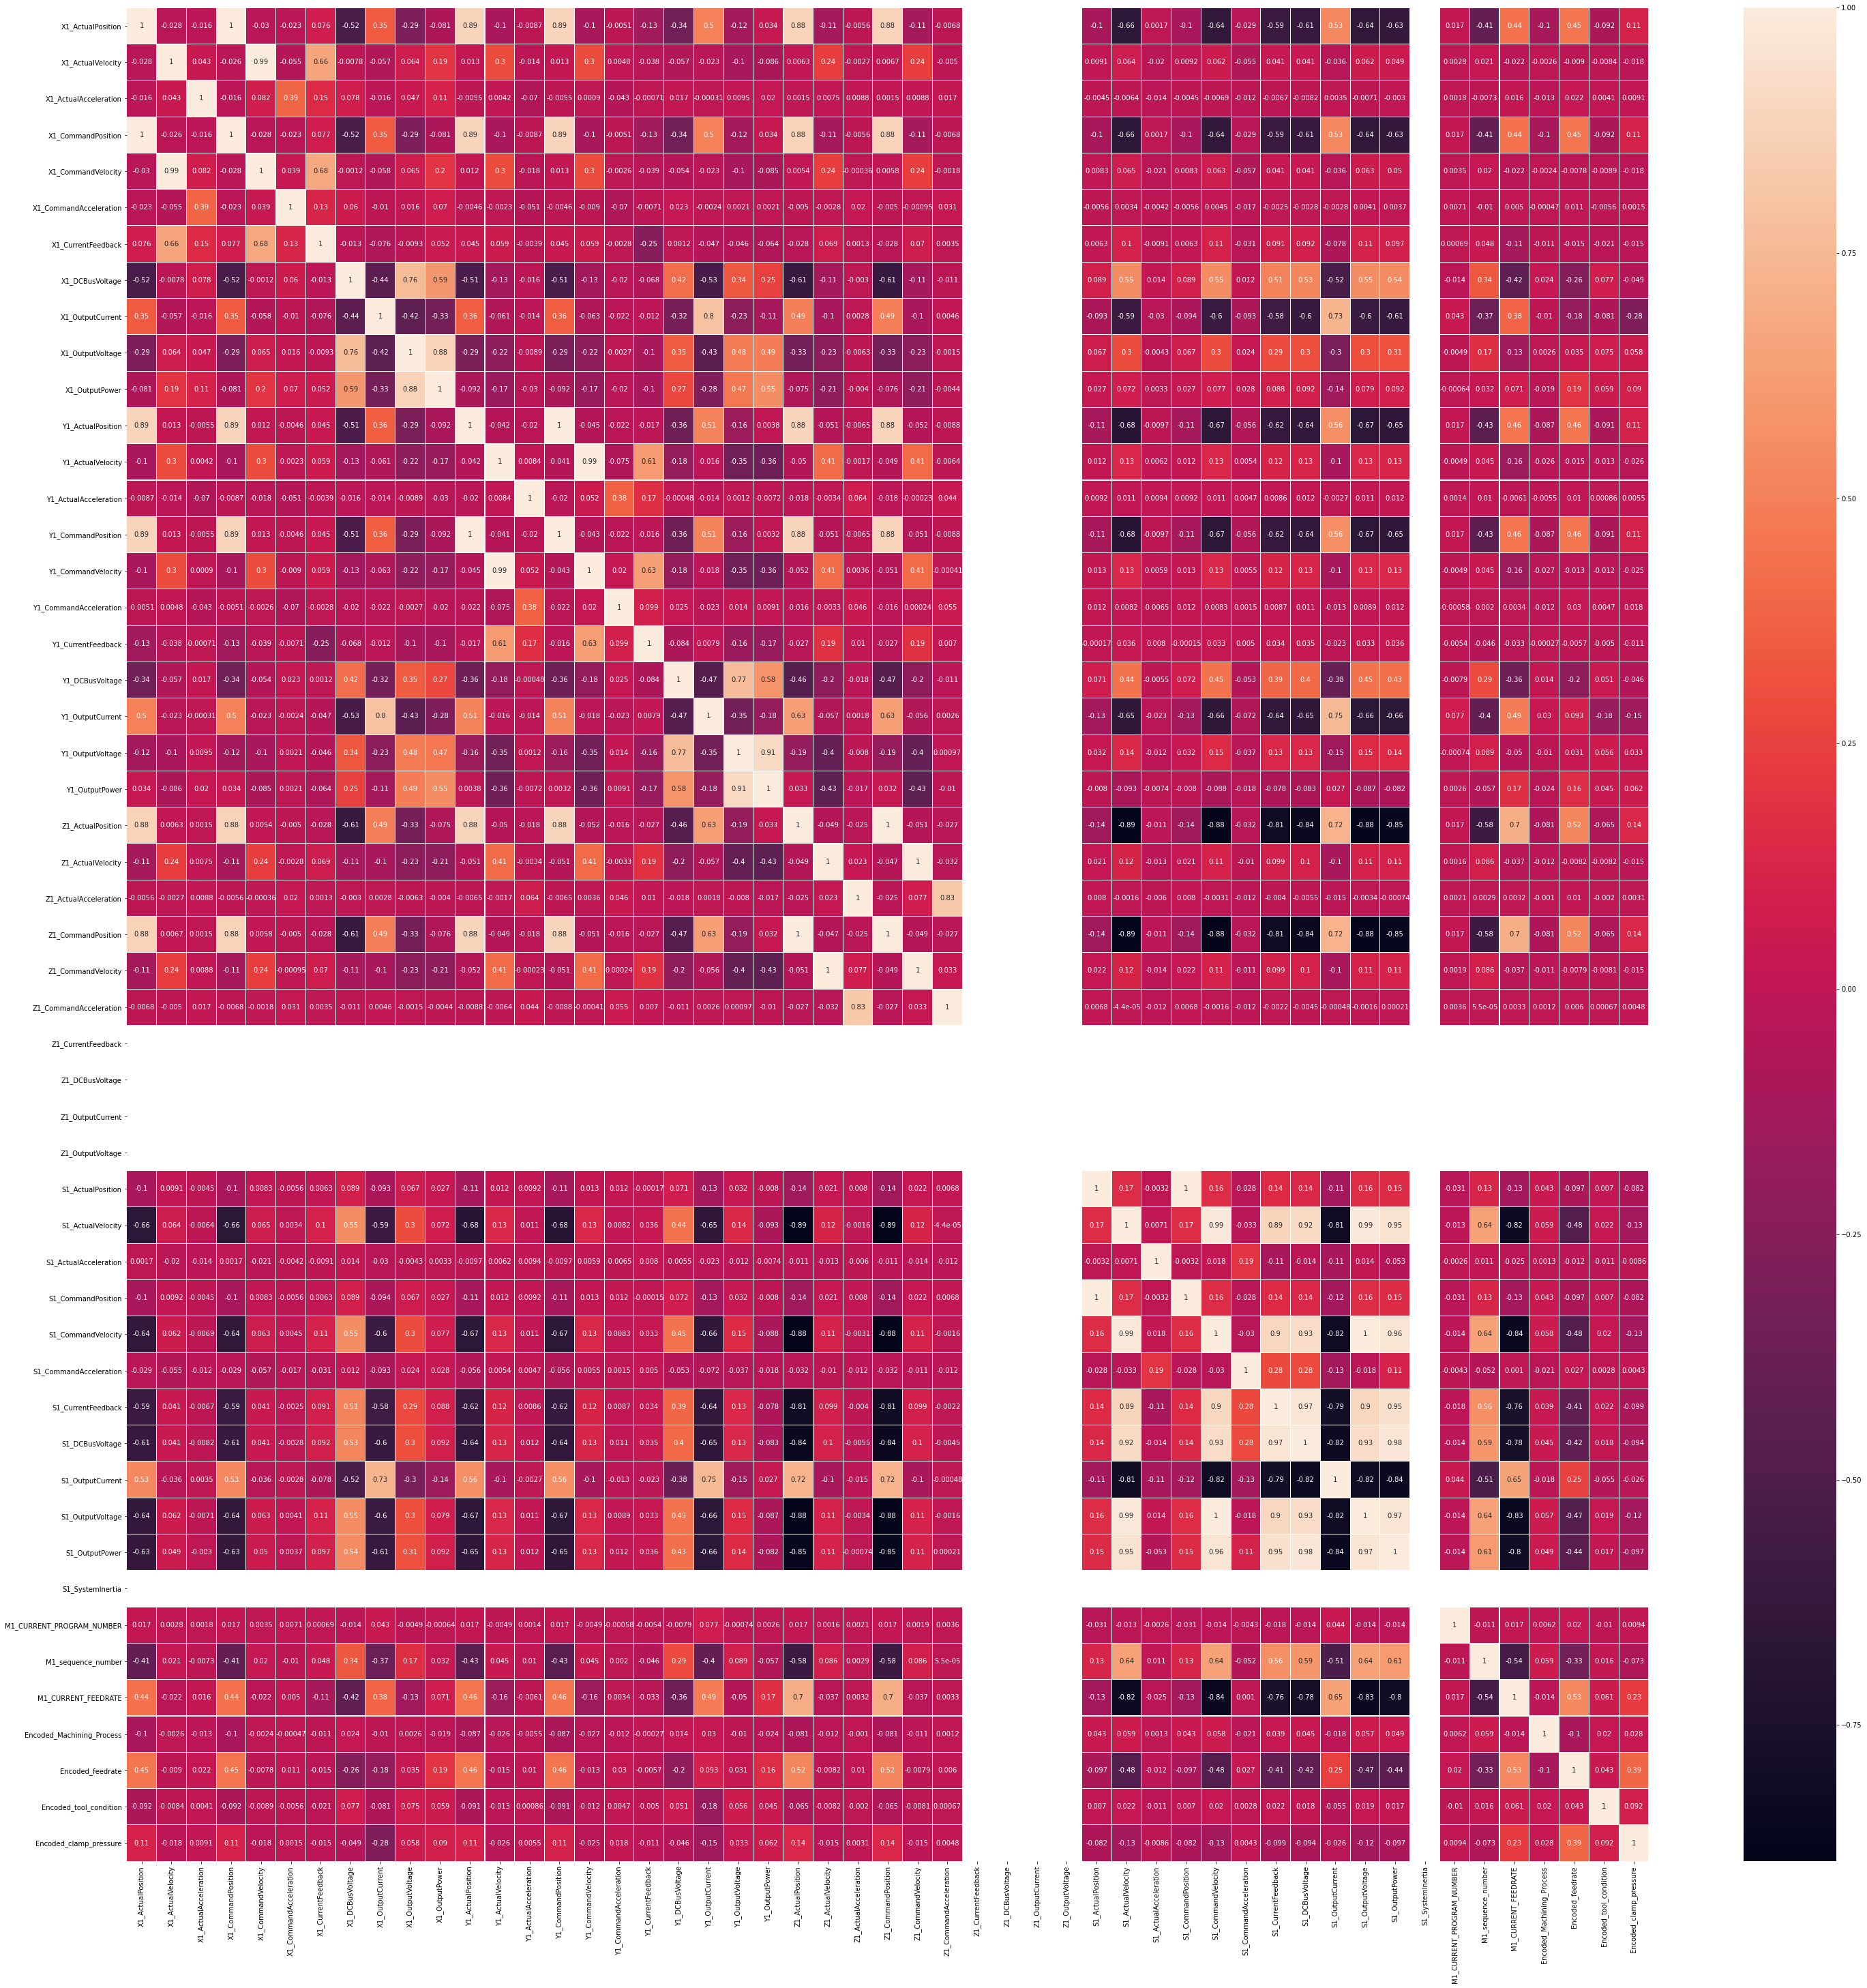

In [159]:
print(">>>>> Heatmap of frames <<<<<")
plt.figure(figsize=(50,50))
sns.heatmap(df.corr(),linewidths=.1,annot=True)
plt.show()
#plt.savefig('fig.png')
#plt.close('all')

        Use function .drop() remove columns by specifying label names

In [160]:
df.drop(['Z1_CurrentFeedback','Z1_DCBusVoltage','Z1_OutputCurrent','Z1_OutputVoltage','S1_SystemInertia'],axis=1,inplace=True)

>>>>> Heatmap of frames after drop column <<<<<


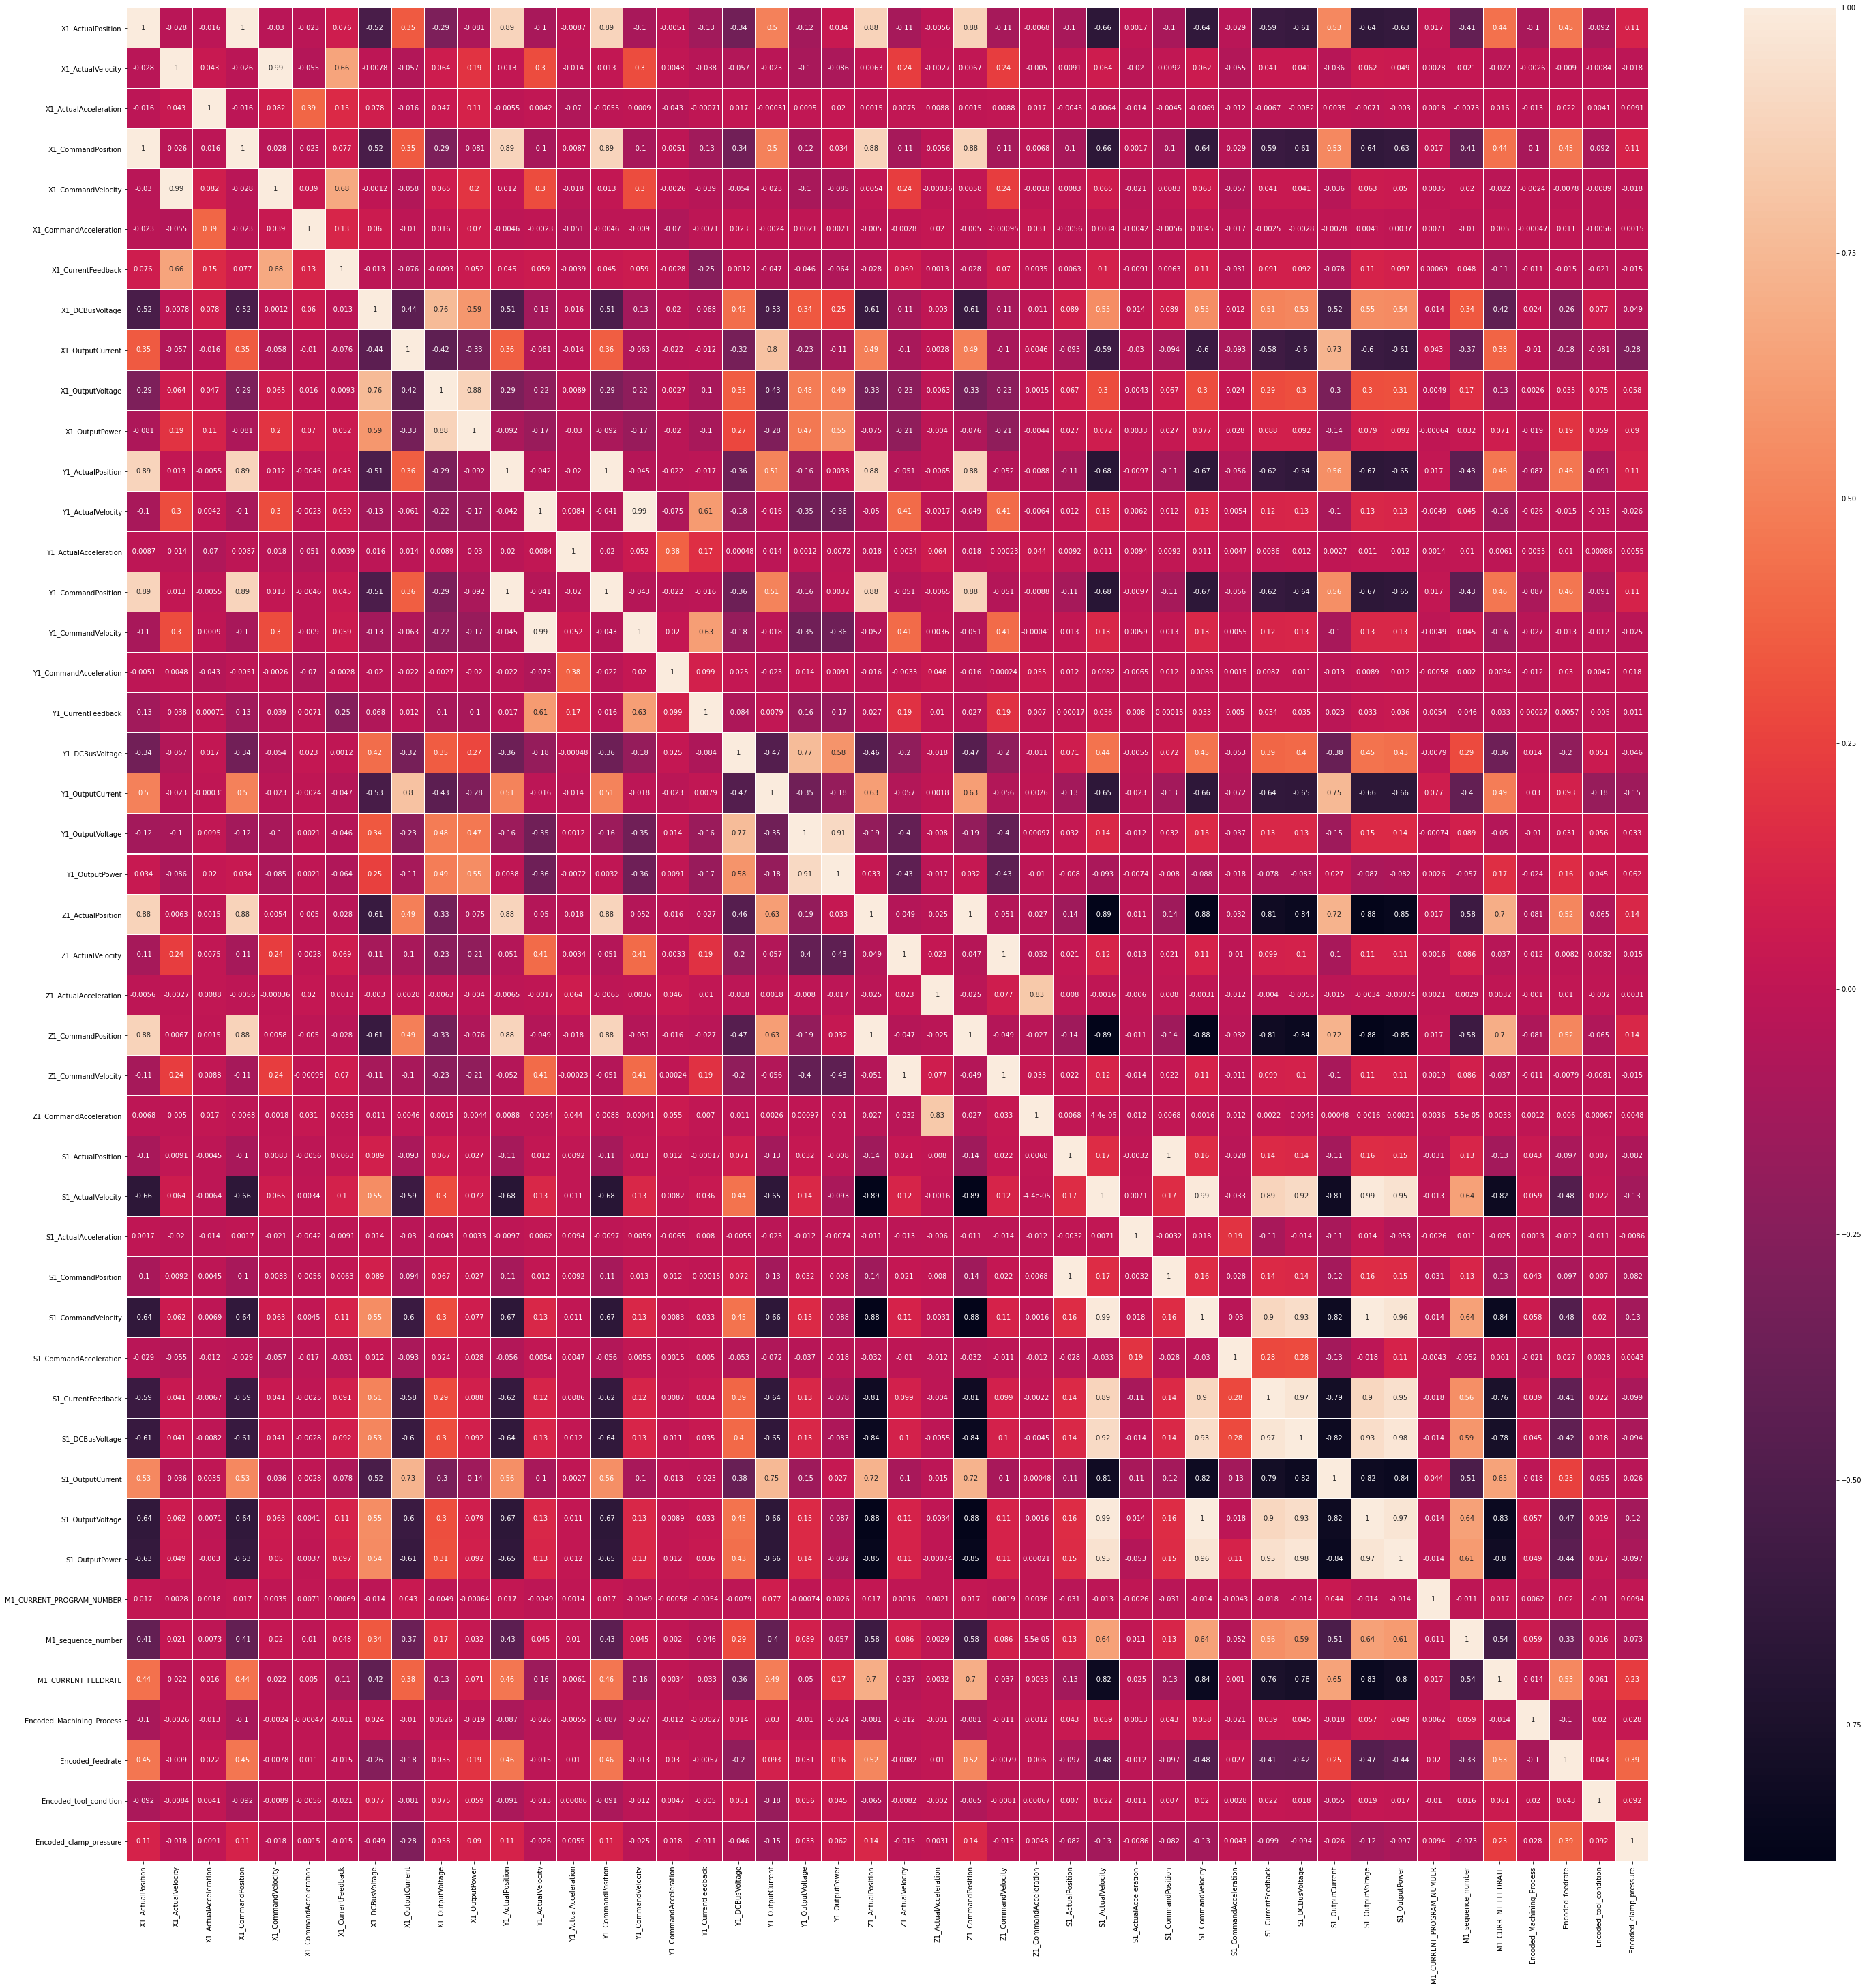

In [161]:
print(">>>>> Heatmap of frames after drop column <<<<<")
plt.figure(figsize=(50,50))
sns.heatmap(df.corr(),linewidths=.1,annot=True)
plt.show()

In [162]:
corr = df.corr()
print("\n>>>>> All features Correlation shape <<<<<")
print(df.corr().shape)


>>>>> All features Correlation shape <<<<<
(46, 46)


In [172]:
print("\n>>>>> Encoded_tool_condition Correlation <<<<<")
cor_tool_condition = abs(corr["Encoded_tool_condition"])
print('>>>>>>>>>> DESCENDING ORDER <<<<<<<<<<')
print(cor_tool_condition.sort_values(axis=0, ascending=False))


>>>>> Encoded_tool_condition Correlation <<<<<
>>>>>>>>>> DESCENDING ORDER <<<<<<<<<<
Encoded_tool_condition       1.000000
Y1_OutputCurrent             0.176805
X1_CommandPosition           0.092029
X1_ActualPosition            0.091920
Encoded_clamp_pressure       0.091545
Y1_CommandPosition           0.090920
Y1_ActualPosition            0.090862
X1_OutputCurrent             0.080973
X1_DCBusVoltage              0.076864
X1_OutputVoltage             0.075167
Z1_CommandPosition           0.064638
Z1_ActualPosition            0.064627
M1_CURRENT_FEEDRATE          0.061106
X1_OutputPower               0.058509
Y1_OutputVoltage             0.056277
S1_OutputCurrent             0.054738
Y1_DCBusVoltage              0.050999
Y1_OutputPower               0.045418
Encoded_feedrate             0.043263
S1_CurrentFeedback           0.022222
S1_ActualVelocity            0.021777
X1_CurrentFeedback           0.020931
S1_CommandVelocity           0.019994
Encoded_Machining_Process    0.019833
S

# **5. Prediction**

**MODEL END-TO-END**

In [164]:
# Drop feats with corr < 0.09
relevant_features = cor_tool_condition[cor_tool_condition >= 0.09]
feat_names = relevant_features.keys().tolist()
feat_names.remove('Encoded_tool_condition')
print(feat_names)

['X1_ActualPosition', 'X1_CommandPosition', 'Y1_ActualPosition', 'Y1_CommandPosition', 'Y1_OutputCurrent', 'Encoded_clamp_pressure']


In [165]:
# Output
y_e2e = df['Encoded_tool_condition']
# Input
#X_e2e = df[feat_names]
X_e2e = df.drop(['Encoded_tool_condition'], axis=1)
print("\n========== y.df(3) ==========")
print(y_e2e.head(3))
print("\n========== X.df(3) ==========")
print(X_e2e.head(3))
X_train_e2e, X_test_e2e, y_train_e2e, y_test_e2e = train_test_split(X_e2e, y_e2e, test_size=0.3, random_state=7)

# Model and training
# LR
LR_e2e = LogisticRegression(C=1e20)
LR_e2e.fit(X_train_e2e, y_train_e2e)

scores_LR = cross_val_score(LR_e2e, X_e2e, y_e2e, cv=5, scoring='accuracy')
print('==========Logistic Regression Cross_Val_Score=======')
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores_LR.mean(), scores_LR.std()))

# DT
DT_e2e = tree.DecisionTreeClassifier()
DT_e2e.fit(X_train_e2e, y_train_e2e)

scores_DT = cross_val_score(DT_e2e, X_e2e, y_e2e, cv=5, scoring='accuracy')
print('==========Decision Tree Cross_Val_Score=======')
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores_DT.mean(), scores_DT.std()))

# SVM
SVM_e2e = svm.SVC()
SVM_e2e.fit(X_train_e2e, y_train_e2e)

scores_SVM = cross_val_score(SVM_e2e, X_e2e, y_e2e, cv=5, scoring='accuracy')
print('==========Support Vector Machine Cross_Val_Score=======')
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores_SVM.mean(), scores_SVM.std()))

# KNN
NC_e2e= NearestCentroid()
NC_e2e.fit(X_train_e2e, y_train_e2e)

scores_NC = cross_val_score(NC_e2e, X_e2e, y_e2e, cv=5, scoring='accuracy')
print('==========K Nearest Neighbors Cross_Val_Score=======')
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores_NC.mean(), scores_NC.std()))




========== y.df(3) ==========
0    0.0
1    0.0
2    0.0
Name: Encoded_tool_condition, dtype: float64

========== X.df(3) ==========
   X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                   0.00   
1              198.0              -10.8                -350.00   
2              196.0              -17.8                  -6.25   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                0.000000   
1               198.0               -13.6             -358.000000   
2               196.0               -17.9               -0.000095   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   
2               -8.59           0.1400             328.0             30.60   

   X1_Outpu

In [175]:
# MLP
MLP_e2e= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 3), random_state=1)
MLP_e2e.fit(X_train_e2e, y_train_e2e)

scores_MLP = cross_val_score(MLP_e2e, X_e2e, y_e2e, cv=5, scoring='accuracy')
print('==========Multi Layer Perceptron Cross_Val_Score=======')
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores_MLP.mean(), scores_MLP.std()))

# SGD
SGD_e2e= SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGD_e2e.fit(X_train_e2e, y_train_e2e)

scores_SGD = cross_val_score(SGD_e2e, X_e2e, y_e2e, cv=5, scoring='accuracy')
print('==========Stochastic Gradient Descend Cross_Val_Score=======')
print("%0.2f accuracy with a standard deviation of %0.2f \n" % (scores_SGD.mean(), scores_SGD.std()))


==========Multi Layer Perceptron Cross_Val_Score=======
0.53 accuracy with a standard deviation of 0.00 

==========Stochastic Gradient Descend Cross_Val_Score=======
0.54 accuracy with a standard deviation of 0.07 



# Results

**Prediction using test set and DT model**

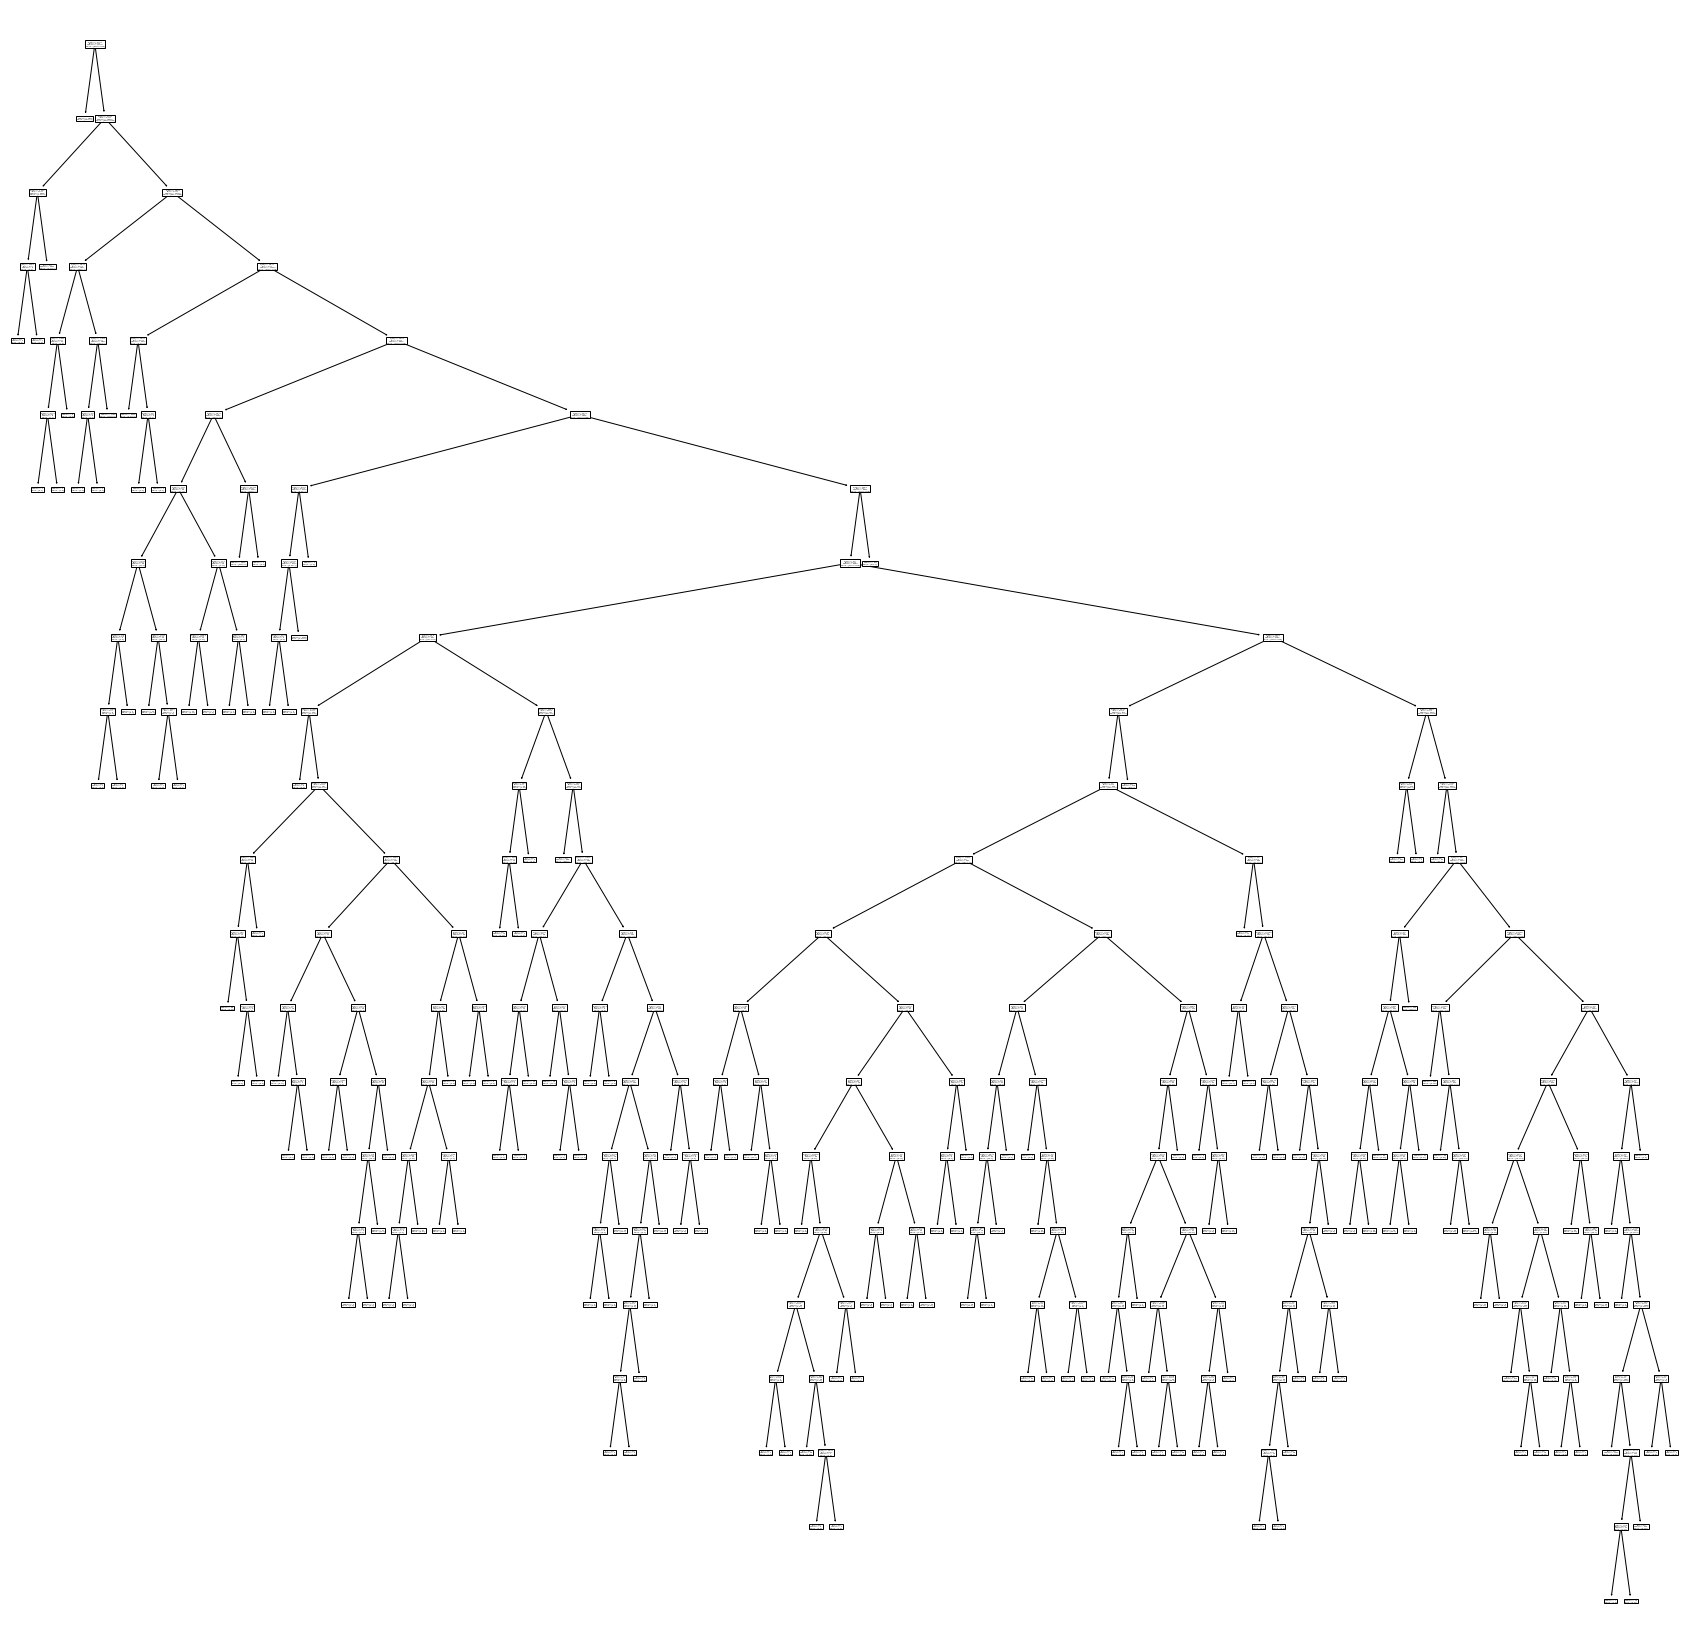

In [169]:
# Plot tree model
plt.figure(figsize=(30,30))
tree.plot_tree(DT_e2e)
plt.show()

In [168]:
# Predict using test set
predictions_tool_condition = DT_e2e.predict(X_test_e2e)
print("\n========== predictions_tool_condition results  ==========")
print(predictions_tool_condition)
print(predictions_tool_condition.shape)


========== predictions_tool_condition results  ==========
[1. 0. 0. ... 0. 1. 1.]
(7586,)
